In [1]:
from tabnet.model import TabNetClassifier
from tabnet.utils import TabNetDataset
import torch
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

import pandas as pd
import numpy as np
np.random.seed(0)

import os
import wget
from pathlib import Path

from matplotlib import pyplot as plt
%matplotlib inline

# Download census-income dataset

In [2]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
dataset_name = 'census-income'
out = Path(os.getcwd()+'/data/'+dataset_name+'.csv')

In [3]:
out.parent.mkdir(parents=True, exist_ok=True)
if out.exists():
    print("File already exists.")
else:
    print("Downloading file...")
    wget.download(url, out.as_posix())

File already exists.


# Load data and split

In [4]:
train = pd.read_csv(out)
target = ' <=50K'
if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p =[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set=="train"].index
valid_indices = train[train.Set=="valid"].index
test_indices = train[train.Set=="test"].index

# Simple preprocessing

Label encode categorical features and fill empty cells.

In [5]:
nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims =  {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

39 73
 State-gov 9
 Bachelors 16
 13 16
 Never-married 7
 Adm-clerical 15
 Not-in-family 6
 White 5
 Male 2
 2174 119
 0 92
 40 94
 United-States 42
 <=50K 2
Set 3


# Define categorical features for categorical embeddings

In [6]:
unused_feat = ['Set']

features = [ col for col in train.columns if col not in unused_feat+[target]]

cat_idxs = [ i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [ categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

In [7]:
X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

In [8]:
pre_train = TabNetDataset(X_train, train=False)
pre_valid = TabNetDataset(X_valid, train=False)
train_dataset = TabNetDataset(X_train, y_train)
valid_dataset = TabNetDataset(X_valid, y_valid)
test_dataset = TabNetDataset(X_test, train=False)

# Network parameters

In [9]:
from tabnet.model import TabNetPretrainer

In [10]:
# TabNetPretrainer
unsupervised_model = TabNetPretrainer(
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    cat_emb_dim=1,
    optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-2),
    mask_type='entmax' # "sparsemax"
)

Device used : cuda


# Self Supervised Training

In [11]:
max_epochs = 5 if not os.getenv("CI", False) else 2

In [12]:
unsupervised_model.fit(
    train_dataset=pre_train,
    eval_datasets=[pre_valid],
    max_epochs=max_epochs,
    patience=5,
    batch_size=2048,
    virtual_batch_size=128,
    num_workers=0,
    drop_last=False,
    pretraining_ratio=0.8,
)

100%|██████████| 2/2 [00:00<00:00, 12.45it/s]


epoch 0  | loss: 2.83904 | val_0_unsup_loss: 1.30929 |  0:00:04s


100%|██████████| 2/2 [00:00<00:00, 17.23it/s]


epoch 1  | loss: 1.28236 | val_0_unsup_loss: 1.25807 |  0:00:06s


100%|██████████| 2/2 [00:00<00:00, 15.57it/s]


epoch 2  | loss: 1.2495  | val_0_unsup_loss: 1.24807 |  0:00:09s


100%|██████████| 2/2 [00:00<00:00, 17.09it/s]


epoch 3  | loss: 1.23288 | val_0_unsup_loss: 1.24242 |  0:00:11s


100%|██████████| 2/2 [00:00<00:00, 16.53it/s]

epoch 4  | loss: 1.23649 | val_0_unsup_loss: 1.23842 |  0:00:14s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_val_0_unsup_loss = 1.23842
Best weights from best epoch are automatically used!


In [13]:
# Make reconstruction from a dataset
reconstructed_X, embedded_X = unsupervised_model.predict(X_valid)
assert(reconstructed_X.shape==embedded_X.shape)

100%|██████████| 2/2 [00:00<00:00, 12.26it/s]


In [14]:
reconstructed_X

array([[ 0.12524559,  0.1675789 ,  0.7011552 , ..., -0.23340064,
         0.3686204 , -0.21515092],
       [ 0.12413462,  0.16544543,  0.60456204, ..., -0.23208268,
         0.25216934, -0.25824213],
       [ 0.11528245,  0.11336119,  0.6811018 , ..., -0.19736958,
         0.34079197, -0.2269954 ],
       ...,
       [ 0.13841149,  0.14710931,  0.7225462 , ..., -0.23578689,
         0.2938611 , -0.30483478],
       [ 0.04267221,  0.10533382,  0.4298526 , ..., -0.11912349,
         0.15695222, -0.17542012],
       [ 0.12850133,  0.12982409,  0.7177874 , ..., -0.22099984,
         0.2960351 , -0.2767051 ]], dtype=float32)

In [15]:
embedded_X

array([[ 1.0204045e+00,  6.9578236e-01,  4.5781000e+04, ...,
        -2.3879975e-01, -1.3936150e+00, -3.4321320e-01],
       [-1.5656660e+00,  6.9578236e-01,  2.8887000e+04, ...,
        -2.3879975e-01, -1.3936150e+00, -3.4321320e-01],
       [ 1.7116945e+00,  6.9578236e-01,  1.9352400e+05, ...,
        -2.3879975e-01, -2.0534492e+00, -3.4321320e-01],
       ...,
       [ 1.5105932e+00, -1.0533671e+00,  1.1919900e+05, ...,
        -2.3879975e-01, -7.7496672e-01, -3.4321320e-01],
       [-2.7062664e-02, -3.1766708e+00,  2.5583500e+05, ...,
        -2.3879975e-01,  9.2657387e-01, -3.4321320e-01],
       [ 1.7116945e+00,  6.9578236e-01,  1.5437400e+05, ...,
        -2.3879975e-01,  9.2657387e-01, -3.4321320e-01]], dtype=float32)

In [16]:
unsupervised_explain_matrix, unsupervised_masks = unsupervised_model.explain(test_dataset)

100%|██████████| 2/2 [00:00<00:00, 18.16it/s]


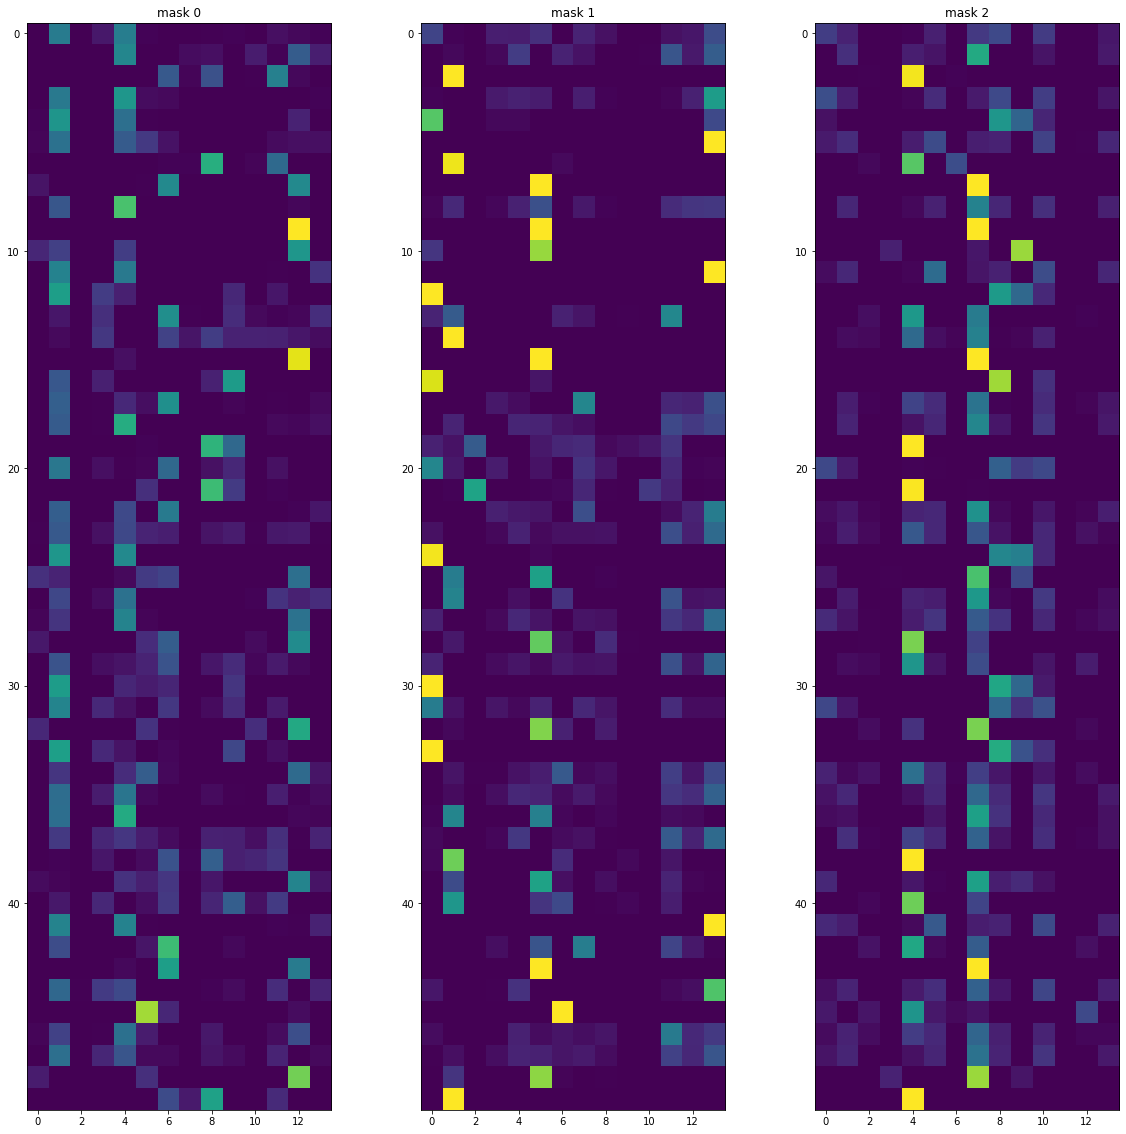

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(unsupervised_masks[i][:50])
    axs[i].set_title(f"mask {i}")


## Save and load the same way as other TabNet models

In [18]:
unsupervised_model.save_model('./test_pretrain')
loaded_pretrain = TabNetPretrainer()
loaded_pretrain.load_model('./test_pretrain.zip')

Successfully saved model at ./test_pretrain.zip
Device used : cuda
Device used : cuda


# Training

In [19]:
clf = TabNetClassifier(optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax' # This will be overwritten if using pretrain model
                      )

Device used : cuda


In [20]:
clf.fit(
    train_dataset=train_dataset,
    eval_datasets=[train_dataset, valid_dataset],
    eval_name=['train', 'valid'],
    eval_metric=['auc'],
    max_epochs=max_epochs , patience=20,
    batch_size=1024, virtual_batch_size=128,
    num_workers=0,
    weights=1,
    drop_last=False,
    from_unsupervised=loaded_pretrain
)

Loading weights from unsupervised pretraining


C:\Users\lzp_9\OneDrive - smail.swufe.edu.cn\projects\TabNetMod\tabnet\model.py:115: UserWarning: Pretraining: cat_dims changed from [] to [73, 9, 16, 16, 7, 15, 6, 5, 2, 119, 92, 94, 42]
  warnings.warn(wrn_msg)
C:\Users\lzp_9\OneDrive - smail.swufe.edu.cn\projects\TabNetMod\tabnet\model.py:115: UserWarning: Pretraining: cat_idxs changed from [] to [0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]
  warnings.warn(wrn_msg)
C:\Users\lzp_9\OneDrive - smail.swufe.edu.cn\projects\TabNetMod\tabnet\model.py:115: UserWarning: Pretraining: mask_type changed from sparsemax to entmax
  warnings.warn(wrn_msg)
100%|██████████| 4/4 [00:00<00:00, 29.76it/s]


epoch 0  | loss: 0.54234 | train_auc: 0.84878 | valid_auc: 0.85425 |  0:00:04s


100%|██████████| 4/4 [00:00<00:00, 28.29it/s]


epoch 1  | loss: 0.43809 | train_auc: 0.88525 | valid_auc: 0.88923 |  0:00:08s


100%|██████████| 4/4 [00:00<00:00, 31.38it/s]


epoch 2  | loss: 0.40181 | train_auc: 0.89946 | valid_auc: 0.89854 |  0:00:11s


100%|██████████| 4/4 [00:00<00:00, 29.87it/s]


epoch 3  | loss: 0.38561 | train_auc: 0.90638 | valid_auc: 0.90711 |  0:00:15s


100%|██████████| 4/4 [00:00<00:00, 30.43it/s]


epoch 4  | loss: 0.36928 | train_auc: 0.90812 | valid_auc: 0.90961 |  0:00:19s
Stop training because you reached max_epochs = 5 with best_epoch = 4 and best_valid_auc = 0.90961
Best weights from best epoch are automatically used!


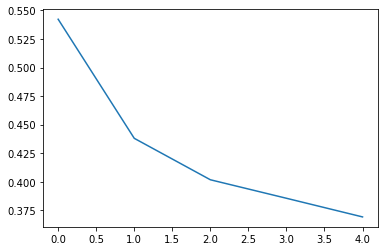

In [21]:
# plot losses
plt.plot(clf.history['loss'])

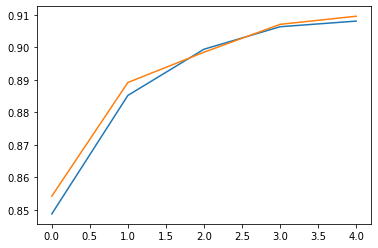

In [22]:
# plot auc
plt.plot(clf.history['train_auc'])
plt.plot(clf.history['valid_auc'])

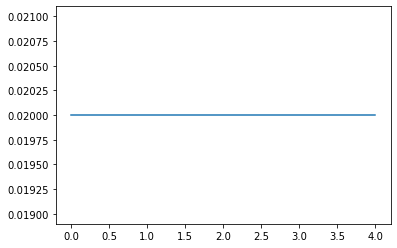

In [23]:
# plot learning rates
plt.plot(clf.history['lr'])

## Predictions

In [24]:
preds = clf.predict_proba(X_test)
test_auc = roc_auc_score(y_score=preds[:,1], y_true=y_test)


preds_valid = clf.predict_proba(X_valid)
valid_auc = roc_auc_score(y_score=preds_valid[:,1], y_true=y_valid)

print(f"BEST VALID SCORE FOR {dataset_name} : {clf.best_cost}")
print(f"FINAL TEST SCORE FOR {dataset_name} : {test_auc}")

BEST VALID SCORE FOR census-income : 0.9096102172018401
FINAL TEST SCORE FOR census-income : 0.9091783650087131


In [25]:
# check that best weights are used
assert np.isclose(valid_auc, np.max(clf.history['valid_auc']), atol=1e-6)

# Save and load Model

In [26]:
temp = {str(index): class_label for index, class_label in enumerate(clf.classes_)}

In [27]:
type(temp['0'])

numpy.int32

In [28]:
# save tabnet model
saving_path_name = "./tabnet_model_test_1"
saved_filepath = clf.save_model(saving_path_name)

Successfully saved model at ./tabnet_model_test_1.zip


In [29]:
# define new model with basic parameters and load state dict weights
loaded_clf = TabNetClassifier()
loaded_clf.load_model(saved_filepath)

Device used : cuda
Device used : cuda


In [30]:
loaded_preds = loaded_clf.predict_proba(X_test)
loaded_test_auc = roc_auc_score(y_score=loaded_preds[:,1], y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset_name} : {loaded_test_auc}")

FINAL TEST SCORE FOR census-income : 0.9091783650087131


In [31]:
assert(test_auc == loaded_test_auc)

# Global explainability : feat importance summing to 1

In [32]:
clf.feature_importances_

array([0.00731786, 0.02084117, 0.00097574, 0.07030499, 0.01538021,
       0.21723189, 0.05616614, 0.08948458, 0.02761694, 0.04193355,
       0.24328861, 0.18283722, 0.02058416, 0.00603693])

# Local explainability and masks

In [33]:
explain_matrix, masks = clf.explain(X_test)

100%|██████████| 4/4 [00:00<00:00, 31.63it/s]


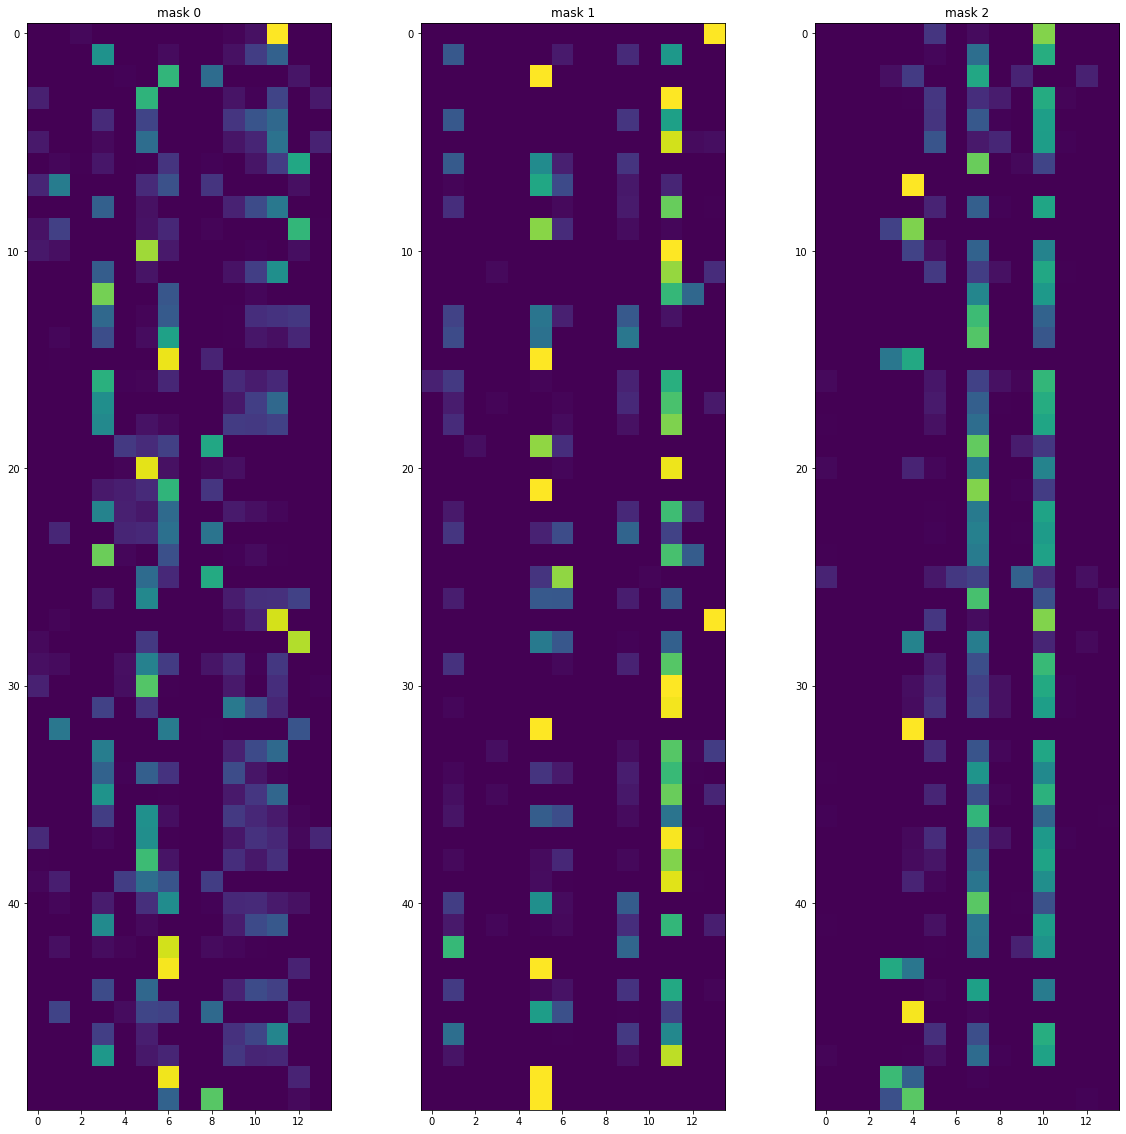

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(20,20))

for i in range(3):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
